Codice per analizzare i dati di segnale e di background sui merged electrons (ME)

In [1]:
# import libraries

import uproot
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# import scikitplot as skplt

import os

In [2]:
# define variables (features)

# discriminating_variables = ["pt", "eta", "phi", "true_E", "Rhad", "Rhad1", 
#                            "Reta", "Rphi", "Eratio", "DeltaE", "wEta1", "wEta2",
#                            "wTotS1"]
discriminating_variables = ["pt", "eta", "true_E", "Rhad", "Rhad1",
                            "Reta", "Rphi", "Eratio", "DeltaE", "f3", "wEta2",
                            "wTotS1", "trk_dEta1", "EoverP",
                            "vtx_dphi", "vtx_deta", "vtx_deltaZ0", 
                            "trk_TRT_PID1", "trk_TRT_PID2"]

variables = ["eventNumber", "pdgId", "parentPdgId", "isLoose", "isTight"] + discriminating_variables


In [3]:
# Read from the sample file
# uproot converts the root format into pandas dataframe

# pick one of many files in MergedElectrons
sf = uproot.open(
    "/storage_tmp/atlas/lnasella/yystar/MergedElectronID"+
    "/Run3/Ntuples/yys_ME002/signal/mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root")
sf.keys()

# signal tree
st = sf["MergedElectron"]
st.keys()


['pt',
 'pt_true',
 'eta',
 'cl_eta',
 'eta_s2',
 'cl_etaCalo',
 'etaModCalo',
 'cellIndexCalo',
 'phi',
 'cl_phi',
 'cl_phiCalo',
 'phiModCalo1',
 'true_E',
 'calibrated_E',
 'cl_E_TileGap3',
 'rawcl_E',
 'rawcl_Eacc',
 'rawcl_Es0',
 'rawcl_Es1',
 'rawcl_Es2',
 'rawcl_Es3',
 'R12',
 'f0',
 'f1',
 'f3',
 'AverageMu',
 'ActualMu',
 'calibrated_E_ph',
 'calibrated_E_ph_50',
 'calibrated_E_ph_100',
 'calibrated_E_ph_200',
 'calibrated_E_ph_400',
 'true_M',
 'reco_M',
 'Rhad',
 'Rhad1',
 'Reta',
 'Rphi',
 'Eratio',
 'DeltaE',
 'wEta1',
 'wEta2',
 'wTotS1',
 'trk_dEta1',
 'trk_abs_dEta1',
 'EoverP',
 'trk1_dphi',
 'trk2_dphi',
 'trk1_deta',
 'trk2_deta',
 'vtx_deltaZ0',
 'delta_R_ll',
 'delta_R_ll_true',
 'm_ll',
 'n_el',
 'n_truth_el',
 'trk_dphi',
 'trk_deta',
 'vtx_dphi',
 'vtx_deta',
 'trk_TRT_PID1',
 'trk_TRT_PID2',
 'trk_d0sig1',
 'trk_d0sig2',
 'vtx_R',
 'passPID',
 'isTight',
 'isMedium',
 'isLoose',
 'eventNumber',
 'runNumber',
 'mcChannelNumber',
 'isIsoWithCorr_Loose',
 'isIsoWi

In [4]:
sd = st.arrays(variables, library="pd")
#st.keys()
#print(st.keys())
sd

,eventNumber,pdgId,parentPdgId,isLoose,isTight,pt,eta,true_E,Rhad,Rhad1,...,f3,wEta2,wTotS1,trk_dEta1,EoverP,vtx_dphi,vtx_deta,vtx_deltaZ0,trk_TRT_PID1,trk_TRT_PID2
0,216001,-11,22,0,0,22.755053,-2.289498,146130.046875,-0.007179,-0.007179,...,0.002777,0.011478,1.152734,0.002138,5.548630,-0.011435,-0.000552,0.114830,-0.000000,-0.000000
1,216035,11,22,1,0,90.648857,-0.126479,-999.000000,0.001414,0.001414,...,0.004400,0.009576,2.288915,0.000310,1.007238,0.004516,-0.001034,161.324081,-0.013623,-0.026559
2,216028,11,11,1,0,69.194923,0.243375,69884.984375,-0.000153,-0.000153,...,0.002733,0.009601,1.959671,0.003101,1.181469,0.000508,0.003027,0.189831,-0.027880,-0.006519
3,216004,11,11,0,0,23.591095,1.128625,83809.289062,-0.003850,0.000377,...,0.003284,0.010591,2.776890,-0.001529,0.472209,0.021275,0.000882,0.028795,0.023110,0.096197
4,216005,-11,-11,1,0,59.034683,0.146982,66662.125000,-0.005290,-0.005290,...,0.004438,0.010150,1.904832,-0.000149,0.993656,0.002240,-0.008324,0.101280,0.003245,0.103180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181031,287990,11,22,1,0,56.414829,-0.474305,62033.531250,-0.004239,-0.004239,...,0.006560,0.008514,1.853502,0.000766,0.905880,0.000956,-0.003099,0.017771,0.040260,0.079115
181032,287988,-11,-11,1,1,50.443615,-1.525999,-999.000000,-0.013511,-0.013511,...,0.005283,0.009479,2.342251,0.000800,-121.618622,-999.000000,-999.000000,69.127274,0.196777,-0.283929
181033,287993,11,11,0,0,41.485275,-0.139478,41810.593750,0.000043,0.000043,...,0.000381,0.008714,1.949105,-0.000091,1.018505,-0.007461,-0.000550,0.044287,0.024207,0.032529
181034,287999,11,11,0,0,27.785141,-2.274886,-999.000000,0.021270,0.021270,...,0.002307,0.012641,1.454068,0.000219,1.207547,-0.002302,0.000559,84.915573,-0.000000,-0.000000


In [5]:
# cut on true_E : true_E = -999 represents ME not matched with a yy*
sd = sd[ (sd["true_E"]!=-999) & (sd["isLoose"]==True)]
print ( "Total number of events after cuts = ", len(sd.index) ) 

Total number of events after cuts =  81851


[Text(0.5, 0, 'eta')]

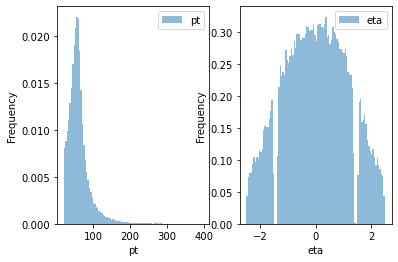

In [6]:
# plot of pt and eta distributions

plt.figure()
plt.subplot(121)
sd[ (sd["pt"] < 400)]["pt"].plot.hist(bins=100,alpha=0.5,density='true',legend='true')
plt.gca().set(xlabel="pt")

plt.subplot(122)
sd["eta"].plot.hist(bins=100,alpha=0.5,density='true',legend='true')
plt.gca().set(xlabel="eta")


In [7]:
# Now read from all the sample files in the directory

# What's the plan:
# 1 - save all file names
# 2 - create a cycle with a temporary data frame
# 3 - add distinctive labels to the data frame and concatenate 
#     with the total data frame (i use pd.concat)

signal_file_names = os.listdir("/storage_tmp/atlas/lnasella/yystar/MergedElectronID"+
                    "/Run3/Ntuples/yys_ME002/signal")

print(signal_file_names)


['mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root', 'mc23a.PhPy8EG_NNPDF23_A14_ggZH125_yys_ME002.root', 'mc23a.PhPy8EG_NNPDF23_A14_ttH125_yys_ME002.root', 'mc23a.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root', 'mc23a.PhPy8EG_NNPDF23_A14_WmH125J_yys_ME002.root', 'mc23a.PhPy8EG_NNPDF23_A14_WpH125J_yys_ME002.root', 'mc23a.PhPy8EG_NNPDF23_A14_ZH125J_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_ggZH125_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_ttH125_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_WmH125J_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_WpH125J_yys_ME002.root', 'mc23d.PhPy8EG_NNPDF23_A14_ZH125J_yys_ME002.root', 'mc23e.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root', 'mc23e.PhPy8EG_NNPDF23_A14_ggZH125_yys_ME002.root', 'mc23e.PhPy8EG_NNPDF23_A14_ttH125_yys_ME002.root', 'mc23e.PhPy8EG_NNPDF23_A14_WmH125J_yys_ME002.root', 'mc23e.PhPy8EG_NNPDF23_A14_WpH125J_yys_ME002.root', 'mc23e.PhPy8EG_NNPD

In [8]:
# step 2

#define total data frame
totald = pd.DataFrame()
count = 0

for file_name in signal_file_names:
    tempf = uproot.open(
        "/storage_tmp/atlas/lnasella/yystar/MergedElectronID"+
        "/Run3/Ntuples/yys_ME002/signal/"+ file_name)
    tempf.keys()
    tempt = tempf["MergedElectron"]
    tempd = tempt.arrays(variables, library="pd")
    
    # step 3
    # lables for signal
    tempd["file_name_label"] = file_name
    tempd["truth_label"] = 1.
    
    # additional labels to distinguish every signal file
    # version of file
    if "mc23a" in file_name:
        tempd["version_label"] = "a"
    elif "mc23d" in file_name:
        tempd["version_label"] = "d"
    else: tempd["version_label"] = "e"
    
    print("File #" + str(count) + ": " + file_name) 
    count += 1
    
    # selection on signal
    tempd = tempd[ (tempd["true_E"]!=-999) & (tempd["isLoose"]==True)]
    
    # concatenate with totald
    #pd.concat([totald, sd], ignore_index=True)
    totald = pd.concat([totald, tempd], axis=0, ignore_index=True)

print("Signal events:")
totald
    

File #0: mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root
File #1: mc23a.PhPy8EG_NNPDF23_A14_ggZH125_yys_ME002.root
File #2: mc23a.PhPy8EG_NNPDF23_A14_ttH125_yys_ME002.root
File #3: mc23a.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root
File #4: mc23a.PhPy8EG_NNPDF23_A14_WmH125J_yys_ME002.root
File #5: mc23a.PhPy8EG_NNPDF23_A14_WpH125J_yys_ME002.root
File #6: mc23a.PhPy8EG_NNPDF23_A14_ZH125J_yys_ME002.root
File #7: mc23d.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root
File #8: mc23d.PhPy8EG_NNPDF23_A14_ggZH125_yys_ME002.root
File #9: mc23d.PhPy8EG_NNPDF23_A14_ttH125_yys_ME002.root
File #10: mc23d.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root
File #11: mc23d.PhPy8EG_NNPDF23_A14_WmH125J_yys_ME002.root
File #12: mc23d.PhPy8EG_NNPDF23_A14_WpH125J_yys_ME002.root
File #13: mc23d.PhPy8EG_NNPDF23_A14_ZH125J_yys_ME002.root
File #14: mc23e.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root
File #15: mc23e.PhPy8EG_NNPDF23_A14_ggZH125_yys_ME002.root
File #16: mc23e.PhPy8EG_NNPDF23_A14_ttH125_yys_ME002.root
File #17: mc23e

,eventNumber,pdgId,parentPdgId,isLoose,isTight,pt,eta,true_E,Rhad,Rhad1,...,trk_dEta1,EoverP,vtx_dphi,vtx_deta,vtx_deltaZ0,trk_TRT_PID1,trk_TRT_PID2,file_name_label,truth_label,version_label
0,216028,11,11,1,0,69.194923,0.243375,69884.984375,-0.000153,-0.000153,...,0.003101,1.181469,0.000508,0.003027,0.189831,-0.027880,-0.006519,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a
1,216005,-11,-11,1,0,59.034683,0.146982,66662.125000,-0.005290,-0.005290,...,-0.000149,0.993656,0.002240,-0.008324,0.101280,0.003245,0.103180,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a
2,216040,11,22,1,1,72.487686,0.485934,81926.343750,-0.000508,-0.000508,...,0.000016,1.128548,-0.004982,-0.001126,0.028361,0.011771,0.005606,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a
3,216008,11,22,1,1,31.882032,0.403211,39761.117188,-0.001891,-0.001891,...,0.000296,1.008108,-0.014281,0.001685,0.095896,-0.041915,-0.012443,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a
4,216017,11,22,1,1,63.155869,-0.323868,65556.718750,-0.000308,-0.000308,...,-0.000544,1.066187,-0.006264,-0.001361,0.078125,0.060672,-0.109327,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825397,869963,-11,22,1,0,33.446518,-1.685298,84792.203125,0.007286,0.007286,...,0.001357,3.391522,0.016002,-0.002204,0.201493,0.127099,-0.205490,mc23e.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root,1.0,e
825398,869988,11,22,1,1,260.735870,0.965048,393299.843750,-0.000965,-0.000577,...,0.000274,1.154701,-0.001492,0.001359,0.001221,-0.065599,-0.288971,mc23e.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root,1.0,e
825399,869982,11,11,1,1,33.056156,1.306312,83042.156250,0.008448,0.009195,...,-0.000106,0.829321,-0.013491,-0.001390,0.204519,0.207857,0.260756,mc23e.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root,1.0,e
825400,869973,11,22,1,1,50.310238,-1.741402,157028.468750,-0.008671,-0.008671,...,0.000232,2.030109,-0.002206,0.000388,0.043613,0.080140,0.187978,mc23e.PhPy8EG_NNPDF23_A14_VBFH125_yys_ME002.root,1.0,e


In [9]:
# read data from background files

bkg_file_names = os.listdir("/storage_tmp/atlas/lnasella/yystar/MergedElectronID"+
                    "/Run3/Ntuples/yys_ME002/bkg")

print(bkg_file_names)

['mc23a.Py8EG_A14NNPDF23LO_perf_JF17.root', 'mc23a.Py8EG_A14NNPDF23LO_perf_JF35.root', 'mc23a.Py8EG_A14NNPDF23LO_perf_JF50.root', 'mc23d.Py8EG_A14NNPDF23LO_perf_JF17.root', 'mc23d.Py8EG_A14NNPDF23LO_perf_JF35.root', 'mc23d.Py8EG_A14NNPDF23LO_perf_JF50.root', 'mc23e.Py8EG_A14NNPDF23LO_perf_JF17.root', 'mc23e.Py8EG_A14NNPDF23LO_perf_JF50.root', 'mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root']


In [10]:
for file_name in bkg_file_names:
    tempf = uproot.open(
        "/storage_tmp/atlas/lnasella/yystar/MergedElectronID"+
        "/Run3/Ntuples/yys_ME002/bkg/"+ file_name)
    tempf.keys()
    tempt = tempf["MergedElectron"]
    tempd = tempt.arrays(variables, library="pd")
    
    # step 3
    # lables for bkg
    tempd["file_name_label"] = file_name
    tempd["truth_label"] = 0.

    # additional labels to distinguish every background file
    # version of file
    if "mc23a" in file_name:
        tempd["version_label"] = "a"
    elif "mc23d" in file_name:
        tempd["version_label"] = "d"
    else: tempd["version_label"] = "e"
    
    # threshold on jet filter
    if "JF17" in file_name:
        tempd["jf_label"] = 17.
    elif "JF35" in file_name:
        tempd["jf_label"] = 35.
    else: tempd["jf_label"] = 50.
    
    # concatenate with totald
    #pd.concat([totald, sd], ignore_index=True)
    totald = pd.concat([totald, tempd], axis=0, ignore_index=True)

print("Total events:")
totald

Total events:


,eventNumber,pdgId,parentPdgId,isLoose,isTight,pt,eta,true_E,Rhad,Rhad1,...,EoverP,vtx_dphi,vtx_deta,vtx_deltaZ0,trk_TRT_PID1,trk_TRT_PID2,file_name_label,truth_label,version_label,jf_label
0,216028,11,11,1,0,69.194923,0.243375,69884.984375,-0.000153,-0.000153,...,1.181469,0.000508,0.003027,0.189831,-0.027880,-0.006519,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN
1,216005,-11,-11,1,0,59.034683,0.146982,66662.125000,-0.005290,-0.005290,...,0.993656,0.002240,-0.008324,0.101280,0.003245,0.103180,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN
2,216040,11,22,1,1,72.487686,0.485934,81926.343750,-0.000508,-0.000508,...,1.128548,-0.004982,-0.001126,0.028361,0.011771,0.005606,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN
3,216008,11,22,1,1,31.882032,0.403211,39761.117188,-0.001891,-0.001891,...,1.008108,-0.014281,0.001685,0.095896,-0.041915,-0.012443,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN
4,216017,11,22,1,1,63.155869,-0.323868,65556.718750,-0.000308,-0.000308,...,1.066187,-0.006264,-0.001361,0.078125,0.060672,-0.109327,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587263,234011663,211,113,0,0,36.597904,-1.521753,-999.000000,0.522742,0.522742,...,0.912994,0.021768,0.013834,0.178782,0.062064,-0.074665,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0
7587264,234011663,-211,21,0,0,34.479755,-1.626309,-999.000000,0.401765,0.401765,...,1.215633,-0.032453,-0.018369,0.032670,0.139856,-0.227623,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0
7587265,234011663,-321,-313,0,0,20.201946,-0.711831,-999.000000,0.335048,0.335048,...,1.131564,-0.007000,0.015375,0.243883,0.043937,-0.029641,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0
7587266,234007958,211,-3,0,0,33.329578,-2.390301,-999.000000,0.017678,0.017678,...,10.989674,0.040467,-0.023224,18.897497,-0.000000,-0.000000,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0


[Text(0.5, 0, 'eta')]

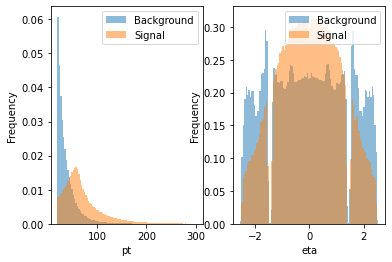

In [11]:
# plot of signal + bkg
# start with pt and eta
plt.figure()
plt.subplot(121)
totald[ (totald["pt"]<300) & (totald["truth_label"]==0)]["pt"].plot.hist(bins=100,alpha=0.5,density='true',label='Background',legend='true')
totald[ (totald["pt"]<300) & (totald["truth_label"]==1)]["pt"].plot.hist(bins=100,alpha=0.5,density='true',label='Signal',legend='true')
plt.gca().set(xlabel="pt")
plt.subplot(122)
totald[ (totald["pt"]<300) & (totald["truth_label"]==0)]["eta"].plot.hist(bins=100,alpha=0.5,density='true',label='Background',legend='true')
totald[ (totald["pt"]<300) & (totald["truth_label"]==1)]["eta"].plot.hist(bins=100,alpha=0.5,density='true',label='Signal',legend='true')
plt.gca().set(xlabel="eta")


In [12]:
print(discriminating_variables)

['pt', 'eta', 'true_E', 'Rhad', 'Rhad1', 'Reta', 'Rphi', 'Eratio', 'DeltaE', 'f3', 'wEta2', 'wTotS1', 'trk_dEta1', 'EoverP', 'vtx_dphi', 'vtx_deta', 'vtx_deltaZ0', 'trk_TRT_PID1', 'trk_TRT_PID2']


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


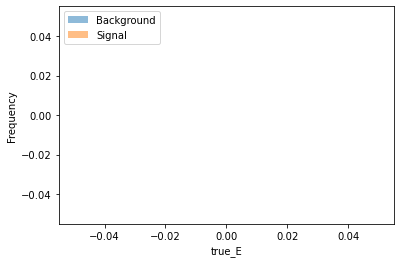

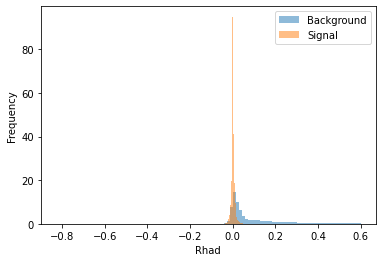

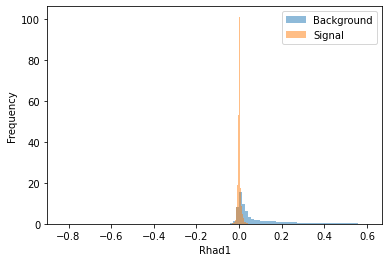

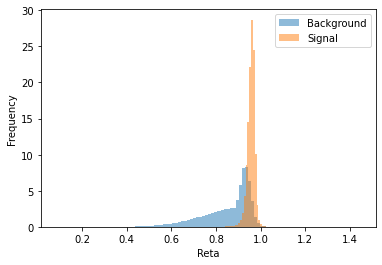

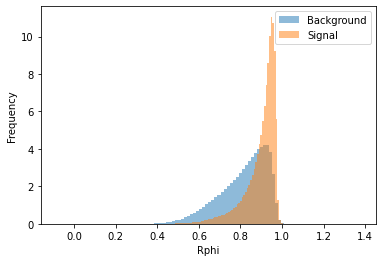

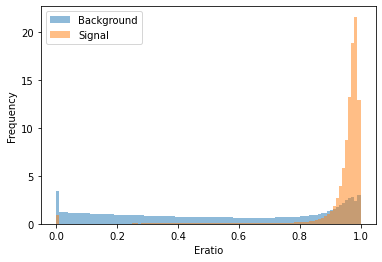

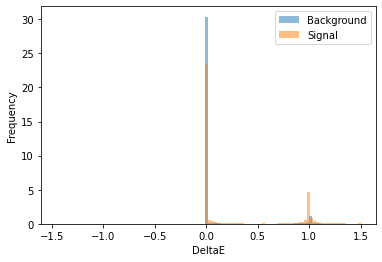

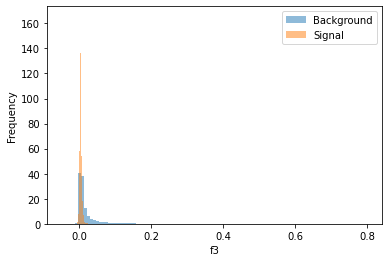

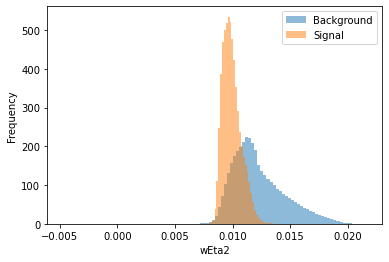

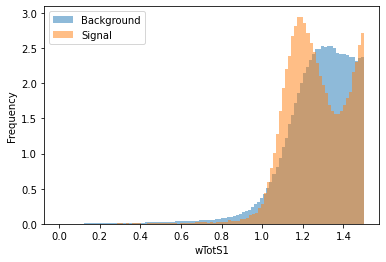

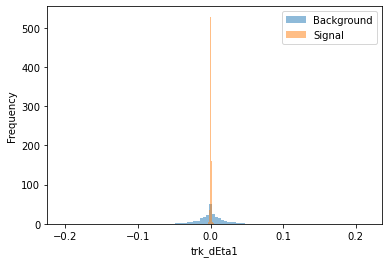

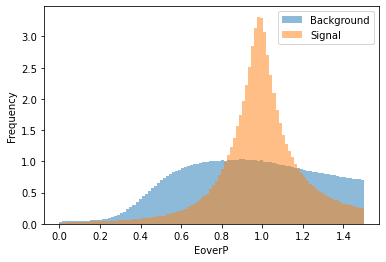

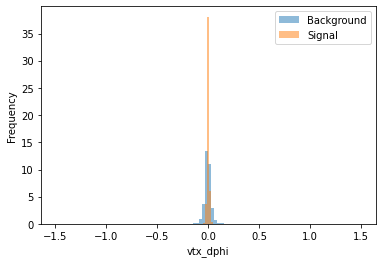

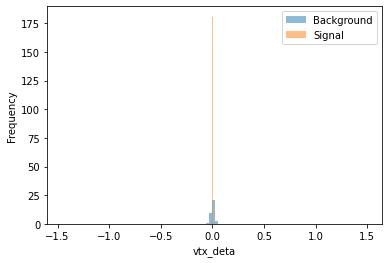

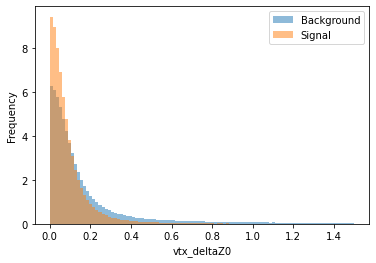

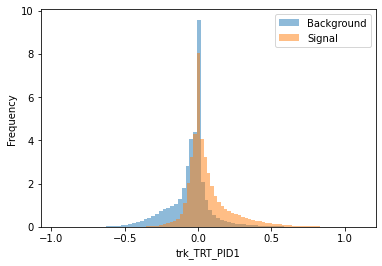

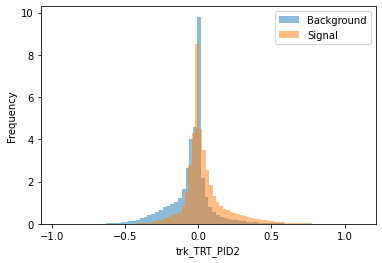

In [13]:
for vname in discriminating_variables:
    if (vname == "pt") | (vname == "eta"): continue
    
    if "Rhad" in vname:
        plt.figure()
        totald[ (totald["truth_label"]==0) & ((totald[vname])<.6)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='Background' , legend='true')
        totald[ (totald["truth_label"]==1) & ((totald[vname])<.6)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='Signal' , legend='true')
        plt.gca().set(xlabel=vname)
    
    elif "TRT_PID" in vname:
        plt.figure()
        totald[ (totald["truth_label"]==0) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=80,alpha=0.5, density='true', label='Background' , legend='true')
        totald[ (totald["truth_label"]==1) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=80,alpha=0.5, density='true', label='Signal' , legend='true')
        plt.gca().set(xlabel=vname)
    
    else: 
        plt.figure()
        totald[ (totald["truth_label"]==0) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='Background' , legend='true')
        totald[ (totald["truth_label"]==1) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='Signal' , legend='true')
        plt.gca().set(xlabel=vname)
        

[Text(0.5, 0, 'eta')]

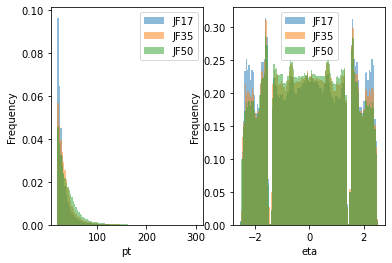

In [14]:
# plot of bkg with different JF
# start with pt and eta

plt.figure()

plt.subplot(121)
totald[ (totald["pt"]<300) & (totald["truth_label"]==0) & (totald["jf_label"]==17)]["pt"].plot.hist(bins=100,alpha=0.5,density='true',label='JF17',legend='true')
totald[ (totald["pt"]<300) & (totald["truth_label"]==0) & (totald["jf_label"]==35)]["pt"].plot.hist(bins=100,alpha=0.5,density='true',label='JF35',legend='true')
totald[ (totald["pt"]<300) & (totald["truth_label"]==0) & (totald["jf_label"]==50)]["pt"].plot.hist(bins=100,alpha=0.5,density='true',label='JF50',legend='true')
plt.gca().set(xlabel="pt")

plt.subplot(122)
totald[ (totald["pt"]<300) & (totald["truth_label"]==0) & (totald["jf_label"]==17)]["eta"].plot.hist(bins=100,alpha=0.5,density='true',label='JF17',legend='true')
totald[ (totald["pt"]<300) & (totald["truth_label"]==0) & (totald["jf_label"]==35)]["eta"].plot.hist(bins=100,alpha=0.5,density='true',label='JF35',legend='true')
totald[ (totald["pt"]<300) & (totald["truth_label"]==0) & (totald["jf_label"]==50)]["eta"].plot.hist(bins=100,alpha=0.5,density='true',label='JF50',legend='true')
plt.gca().set(xlabel="eta")


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


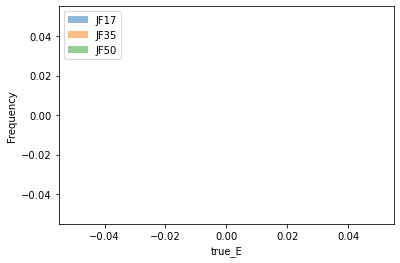

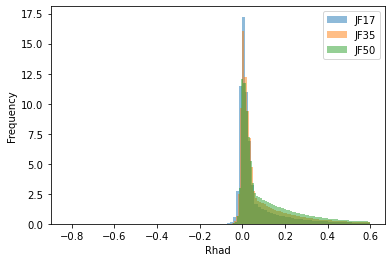

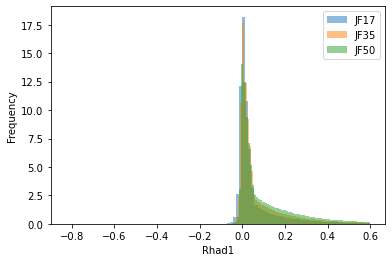

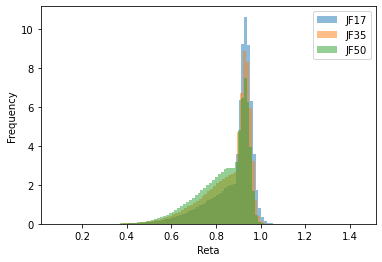

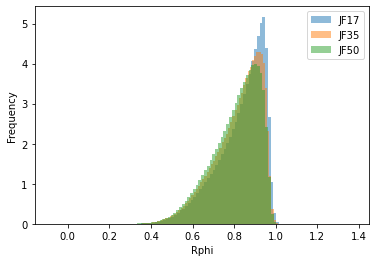

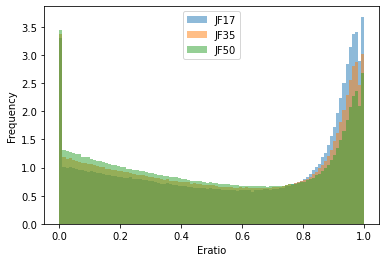

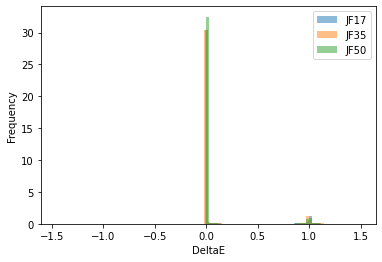

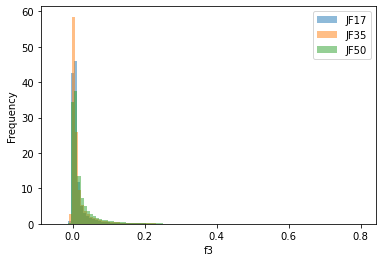

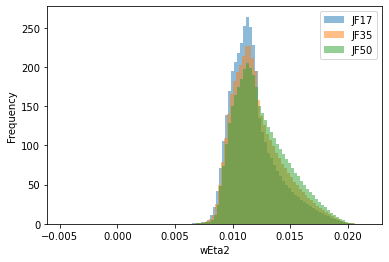

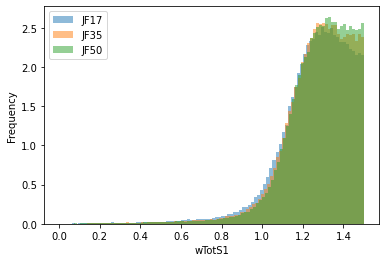

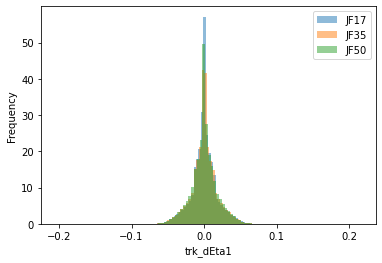

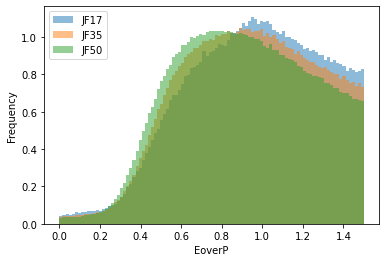

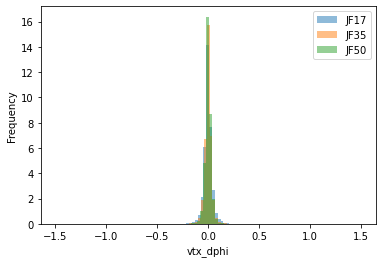

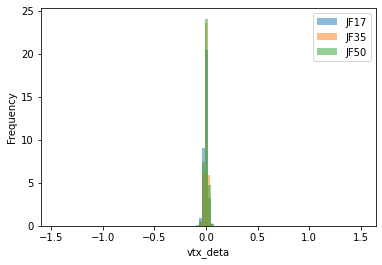

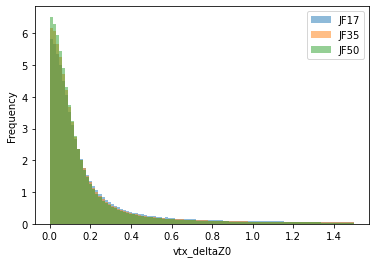

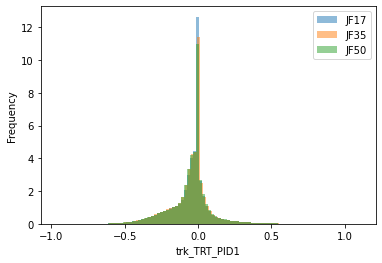

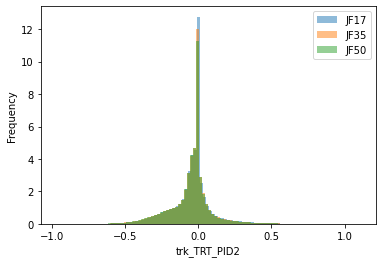

In [15]:
for vname in discriminating_variables:
    if (vname == "pt") | (vname == "eta"): continue
    
    if "Rhad" in vname:
        plt.figure()
        totald[ (totald["truth_label"]==0) & (totald["jf_label"]==17) & ((totald[vname])<.6)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='JF17' , legend='true')
        totald[ (totald["truth_label"]==0) & (totald["jf_label"]==35) & ((totald[vname])<.6)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='JF35' , legend='true')
        totald[ (totald["truth_label"]==0) & (totald["jf_label"]==50) & ((totald[vname])<.6)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='JF50' , legend='true')
        plt.gca().set(xlabel=vname)
    
    else: 
        plt.figure()
        totald[ (totald["truth_label"]==0) & (totald["jf_label"]==17) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='JF17' , legend='true')
        totald[ (totald["truth_label"]==0) & (totald["jf_label"]==35) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='JF35' , legend='true')
        totald[ (totald["truth_label"]==0) & (totald["jf_label"]==50) & (abs(totald[vname])<1.5)][vname].plot.hist(bins=100,alpha=0.5, density='true', label='JF50' , legend='true')
        plt.gca().set(xlabel=vname)

[Text(0.5, 0, 'DeltaE')]

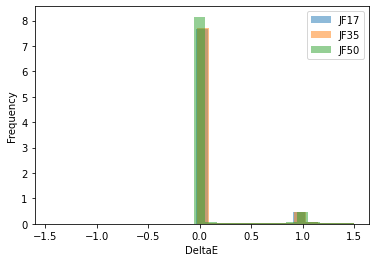

In [16]:
plt.figure()
totald[ (totald["truth_label"]==0) & (totald["jf_label"]==17) & (abs(totald["DeltaE"])<1.5)]["DeltaE"].plot.hist(bins=25,alpha=0.5, density='true', label='JF17' , legend='true')
totald[ (totald["truth_label"]==0) & (totald["jf_label"]==35) & (abs(totald["DeltaE"])<1.5)]["DeltaE"].plot.hist(bins=25,alpha=0.5, density='true', label='JF35' , legend='true')
totald[ (totald["truth_label"]==0) & (totald["jf_label"]==50) & (abs(totald["DeltaE"])<1.5)]["DeltaE"].plot.hist(bins=25,alpha=0.5, density='true', label='JF50' , legend='true')
plt.gca().set(xlabel="DeltaE")

In [17]:
# set "global" weights depending on statistics of every file

# 1. mc23a: 31.4 fb^(-1)
# 2. mc23d: 27.8 fb^(-1)
# 3. mc23e: 109.8 fb^(-1)

totald["weight_glob"] = pd.Series(dtype='float')

totald.loc[(totald["version_label"] == 'a', "weight_glob")] = 31.4
totald.loc[(totald["version_label"] == 'd', "weight_glob")] = 27.8
totald.loc[(totald["version_label"] == 'e', "weight_glob")] = 109.8


In [18]:
totald

,eventNumber,pdgId,parentPdgId,isLoose,isTight,pt,eta,true_E,Rhad,Rhad1,...,vtx_dphi,vtx_deta,vtx_deltaZ0,trk_TRT_PID1,trk_TRT_PID2,file_name_label,truth_label,version_label,jf_label,weight_glob
0,216028,11,11,1,0,69.194923,0.243375,69884.984375,-0.000153,-0.000153,...,0.000508,0.003027,0.189831,-0.027880,-0.006519,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4
1,216005,-11,-11,1,0,59.034683,0.146982,66662.125000,-0.005290,-0.005290,...,0.002240,-0.008324,0.101280,0.003245,0.103180,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4
2,216040,11,22,1,1,72.487686,0.485934,81926.343750,-0.000508,-0.000508,...,-0.004982,-0.001126,0.028361,0.011771,0.005606,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4
3,216008,11,22,1,1,31.882032,0.403211,39761.117188,-0.001891,-0.001891,...,-0.014281,0.001685,0.095896,-0.041915,-0.012443,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4
4,216017,11,22,1,1,63.155869,-0.323868,65556.718750,-0.000308,-0.000308,...,-0.006264,-0.001361,0.078125,0.060672,-0.109327,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587263,234011663,211,113,0,0,36.597904,-1.521753,-999.000000,0.522742,0.522742,...,0.021768,0.013834,0.178782,0.062064,-0.074665,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8
7587264,234011663,-211,21,0,0,34.479755,-1.626309,-999.000000,0.401765,0.401765,...,-0.032453,-0.018369,0.032670,0.139856,-0.227623,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8
7587265,234011663,-321,-313,0,0,20.201946,-0.711831,-999.000000,0.335048,0.335048,...,-0.007000,0.015375,0.243883,0.043937,-0.029641,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8
7587266,234007958,211,-3,0,0,33.329578,-2.390301,-999.000000,0.017678,0.017678,...,0.040467,-0.023224,18.897497,-0.000000,-0.000000,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8


In [19]:
# weights on bin of p_t and eta:
# I need to make signal and bkg (weighted) distributions equal

In [20]:
# **weight eta**
# fixed min and max
etamin = -2.6
etamax = 2.6
# etamin = totald["eta"].min()
# etamax = totald["eta"].max()
nbins_eta = 52
eta_bins = np.linspace(etamin, etamax, nbins_eta+1)


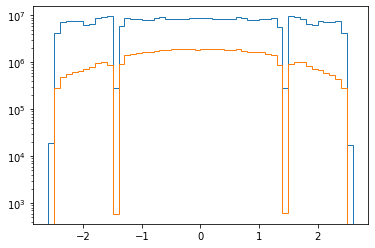

In [21]:
# histograms

h_eta_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["eta"] ,
                     weights = totald[ totald["truth_label"]==0 ]["weight_glob"],
                     histtype='step', log = True, bins = eta_bins )

h_eta_sig = plt.hist( totald[ totald["truth_label"]==1 ]["eta"] ,
                     weights = totald[ totald["truth_label"]==1 ]["weight_glob"],
                     histtype='step', log = True, bins = eta_bins )

In [22]:
# weight_eta calclulation (ratio between bins)

eta_w = np.where(h_eta_bkg[0] == 0 , 1., h_eta_sig[0] / h_eta_bkg[0])
eta_w

array([0.        , 0.06982651, 0.06482054, 0.07540076, 0.08200925,
       0.0872595 , 0.11565213, 0.11814195, 0.11164148, 0.11074683,
       0.09241965, 0.00210542, 0.15143202, 0.15943209, 0.17497371,
       0.19174238, 0.20567327, 0.20697233, 0.20069692, 0.2001183 ,
       0.21627399, 0.22597323, 0.22231935, 0.2209439 , 0.22158584,
       0.21406736, 0.21560947, 0.21818151, 0.22456395, 0.22961328,
       0.21967322, 0.21653207, 0.20223807, 0.19979227, 0.21064229,
       0.20775212, 0.19658809, 0.17973432, 0.1589414 , 0.15406527,
       0.00216433, 0.09508995, 0.11297726, 0.11635312, 0.12316001,
       0.11664469, 0.0905558 , 0.08056956, 0.07164252, 0.05842374,
       0.06757392, 0.        ])

In [23]:
# calcultate for each (not only bkg!) event what bin it belongs to

bin_idx_bkg_eta = np.digitize(totald["eta"], eta_bins)
idx_bkg_eta = pd.Series(bin_idx_bkg_eta)
idx_bkg_eta

0          29
1          28
2          31
3          31
4          23
           ..
7587263    11
7587264    10
7587265    19
7587266     3
7587267    33
Length: 7587268, dtype: int64

In [24]:
# map every bin to the corresponding weight

dfw_bkg_eta = idx_bkg_eta.map({i+1 : eta_w[i] for i in range(nbins_eta)})
dfw_bkg_eta

0          0.224564
1          0.218182
2          0.219673
3          0.219673
4          0.222319
             ...   
7587263    0.092420
7587264    0.110747
7587265    0.200697
7587266    0.064821
7587267    0.202238
Length: 7587268, dtype: float64

In [25]:
# attach weights to the dataframe, with condition on signal events

totald["weight_eta"] = dfw_bkg_eta.where( totald["truth_label"]==0 , 1.)
totald["weight_eta"]


0          1.000000
1          1.000000
2          1.000000
3          1.000000
4          1.000000
             ...   
7587263    0.092420
7587264    0.110747
7587265    0.200697
7587266    0.064821
7587267    0.202238
Name: weight_eta, Length: 7587268, dtype: float64

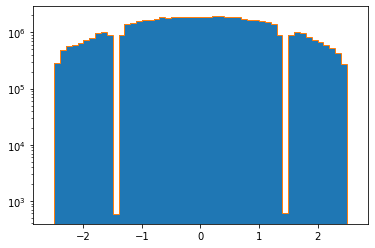

In [26]:
# histograms
h_eta_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["eta"] ,
                     weights = totald[ totald["truth_label"]==0 ]["weight_eta"] * totald[ totald["truth_label"]==0 ]["weight_glob"],
                     histtype='stepfilled', bins = eta_bins )


h_eta_sig = plt.hist( totald[ totald["truth_label"]==1 ]["eta"] ,
                     weights = totald[ totald["truth_label"]==1 ]["weight_eta"] * totald[ totald["truth_label"]==1 ]["weight_glob"],
                     histtype='step', log = True, bins = eta_bins )

In [27]:
# **weight pt**
# bins depending on max pt of the dataframe

ptmin = 0.
ptmax = totald["pt"].max()
nbins_pt = 50
pt_bins = np.linspace(ptmin, ptmax, nbins_pt + 1)


[Text(0.5, 0, 'pt')]

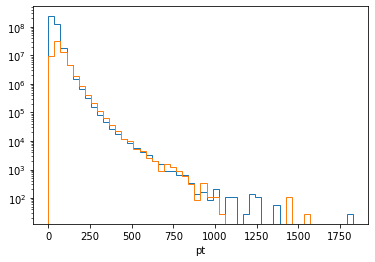

In [28]:
# histograms

h_pt_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["pt"] ,
                     weights = totald[ totald["truth_label"]==0 ]["weight_glob"],
                     histtype='step', log = True, bins = pt_bins )

h_pt_sig = plt.hist( totald[ totald["truth_label"]==1 ]["pt"] ,
                     weights = totald[ totald["truth_label"]==1 ]["weight_glob"],
                     histtype='step', log = True, bins = pt_bins )
plt.gca().set(xlabel="pt")

In [29]:
# weight calculation

# problem: i have to consider bins where there are ONLY signal or background events

# pt_w = np.where( h_pt_bkg[0] != 0, h_pt_sig[0] / h_pt_bkg[0], 1.)    
pt_w = np.where( h_pt_bkg[0] == 0, 1., h_pt_sig[0] / h_pt_bkg[0])
pt_w

/tmp/ipykernel_27389/378228968.py:6: RuntimeWarning: divide by zero encountered in true_divide
  pt_w = np.where( h_pt_bkg[0] == 0, 1., h_pt_sig[0] / h_pt_bkg[0])
/tmp/ipykernel_27389/378228968.py:6: RuntimeWarning: invalid value encountered in true_divide
  pt_w = np.where( h_pt_bkg[0] == 0, 1., h_pt_sig[0] / h_pt_bkg[0])


array([0.03944032, 0.25446529, 0.71011357, 1.04790674, 1.28711113,
       1.32886872, 1.29994355, 1.31583606, 1.33228227, 1.39963291,
       1.39985162, 1.34275739, 1.04395739, 1.11242739, 0.91205775,
       1.11691085, 0.82209048, 1.02116507, 0.60002634, 1.86660469,
       1.30759076, 1.34995267, 0.92044025, 0.93772672, 0.60610465,
       1.99153567, 1.31654676, 0.53823529, 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ])

In [30]:
# calcultate for each (not only bkg!) event what bin it belongs to

bin_idx_bkg_pt = np.digitize(totald["pt"], pt_bins)
idx_bkg_pt = pd.Series(bin_idx_bkg_pt)
idx_bkg_pt

0          2
1          2
2          2
3          1
4          2
          ..
7587263    2
7587264    1
7587265    1
7587266    1
7587267    2
Length: 7587268, dtype: int64

In [31]:
# map every bin to the corresponding weight

dfw_bkg_pt = idx_bkg_pt.map({i+1 : pt_w[i] for i in range(nbins_pt)})
dfw_bkg_pt

0          0.254465
1          0.254465
2          0.254465
3          0.039440
4          0.254465
             ...   
7587263    0.254465
7587264    0.039440
7587265    0.039440
7587266    0.039440
7587267    0.254465
Length: 7587268, dtype: float64

In [32]:
# attach weights to the dataframe, with condition on signal events

totald["weight_pt"] = dfw_bkg_pt.where( totald["truth_label"]==0 , 1.)
totald["weight_pt"]

0          1.000000
1          1.000000
2          1.000000
3          1.000000
4          1.000000
             ...   
7587263    0.254465
7587264    0.039440
7587265    0.039440
7587266    0.039440
7587267    0.254465
Name: weight_pt, Length: 7587268, dtype: float64

In [33]:
totald

,eventNumber,pdgId,parentPdgId,isLoose,isTight,pt,eta,true_E,Rhad,Rhad1,...,vtx_deltaZ0,trk_TRT_PID1,trk_TRT_PID2,file_name_label,truth_label,version_label,jf_label,weight_glob,weight_eta,weight_pt
0,216028,11,11,1,0,69.194923,0.243375,69884.984375,-0.000153,-0.000153,...,0.189831,-0.027880,-0.006519,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4,1.000000,1.000000
1,216005,-11,-11,1,0,59.034683,0.146982,66662.125000,-0.005290,-0.005290,...,0.101280,0.003245,0.103180,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4,1.000000,1.000000
2,216040,11,22,1,1,72.487686,0.485934,81926.343750,-0.000508,-0.000508,...,0.028361,0.011771,0.005606,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4,1.000000,1.000000
3,216008,11,22,1,1,31.882032,0.403211,39761.117188,-0.001891,-0.001891,...,0.095896,-0.041915,-0.012443,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4,1.000000,1.000000
4,216017,11,22,1,1,63.155869,-0.323868,65556.718750,-0.000308,-0.000308,...,0.078125,0.060672,-0.109327,mc23a.PhPy8EG_NNPDF23_A14_ggH125_yys_ME002.root,1.0,a,NaN,31.4,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587263,234011663,211,113,0,0,36.597904,-1.521753,-999.000000,0.522742,0.522742,...,0.178782,0.062064,-0.074665,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8,0.092420,0.254465
7587264,234011663,-211,21,0,0,34.479755,-1.626309,-999.000000,0.401765,0.401765,...,0.032670,0.139856,-0.227623,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8,0.110747,0.039440
7587265,234011663,-321,-313,0,0,20.201946,-0.711831,-999.000000,0.335048,0.335048,...,0.243883,0.043937,-0.029641,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8,0.200697,0.039440
7587266,234007958,211,-3,0,0,33.329578,-2.390301,-999.000000,0.017678,0.017678,...,18.897497,-0.000000,-0.000000,mc23e.Py8EG_A14NNPDF23LO_perf_JF35.root,0.0,e,35.0,109.8,0.064821,0.039440


[Text(0.5, 0, 'eta')]

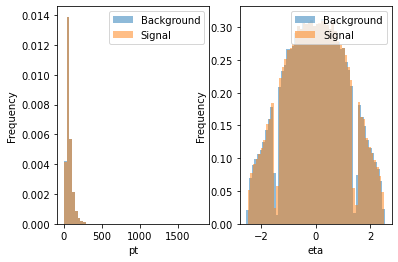

In [34]:
# **weighted** plot of signal + bkg

plt.figure()
plt.subplot(121)
totald[ (totald["pt"]<300) & (totald["truth_label"]==0)]["pt"].plot.hist(bins=pt_bins,alpha=0.5,density='true',label='Background',legend='true', 
                                                                         weights=totald[ (totald["pt"]<300) & (totald["truth_label"]==0)]["weight_pt"])
totald[ (totald["pt"]<300) & (totald["truth_label"]==1)]["pt"].plot.hist(bins=pt_bins,alpha=0.5,density='true',label='Signal',legend='true', 
                                                                         weights=totald[ (totald["pt"]<300) & (totald["truth_label"]==1)]["weight_pt"])
plt.gca().set(xlabel="pt")
plt.subplot(122)
totald[ (totald["pt"]<300) & (totald["truth_label"]==0)]["eta"].plot.hist(bins=nbins_eta,alpha=0.5,density='true',label='Background',legend='true', 
                                                                          weights=totald[ (totald["pt"]<300) & (totald["truth_label"]==0)]["weight_eta"])
totald[ (totald["pt"]<300) & (totald["truth_label"]==1)]["eta"].plot.hist(bins=nbins_eta,alpha=0.5,density='true',label='Signal',legend='true', 
                                                                          weights=totald[ (totald["pt"]<300) & (totald["truth_label"]==1)]["weight_eta"])
plt.gca().set(xlabel="eta")

[Text(0.5, 0, 'pt')]

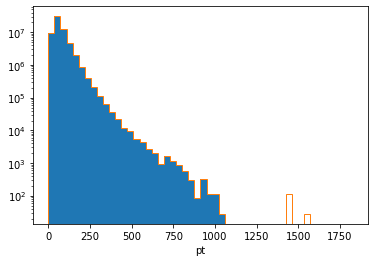

In [35]:
# histograms

h_pt_bkg_w = plt.hist( totald[ totald["truth_label"]==0 ]["pt"] ,
                     weights = totald[ totald["truth_label"]==0 ]["weight_pt"] * totald[ totald["truth_label"]==0 ]["weight_glob"],
                     histtype='stepfilled', log = True, bins = pt_bins )

h_pt_sig_w = plt.hist( totald[ totald["truth_label"]==1 ]["pt"] ,
                     weights = totald[ totald["truth_label"]==1 ]["weight_pt"] * totald[ totald["truth_label"]==1 ]["weight_glob"],
                     histtype='step', log = True, bins = pt_bins )
plt.gca().set(xlabel="pt")

In [36]:
# try to create a binning of pt without empty bins
# solution: i create bin starting from quantiles

totald["pt"]

0          69.194923
1          59.034683
2          72.487686
3          31.882032
4          63.155869
             ...    
7587263    36.597904
7587264    34.479755
7587265    20.201946
7587266    33.329578
7587267    45.453854
Name: pt, Length: 7587268, dtype: float32

In [37]:
edge_var_pt = np.percentile(totald["pt"][ totald["truth_label"]==1 ], np.linspace(0, 100, nbins_pt + 1))
edge_var_pt

array([  20.00011826,   22.53387592,   24.99445114,   27.32638313,
         29.54048584,   31.59573593,   33.59473083,   35.51559387,
         37.3269046 ,   39.06497086,   40.71513977,   42.3111763 ,
         43.82528198,   45.30746559,   46.73281754,   48.13523331,
         49.49093964,   50.79917679,   52.08145142,   53.33033188,
         54.57014084,   55.78090446,   56.98805847,   58.18824905,
         59.41526016,   60.64873505,   61.93653641,   63.25086426,
         64.66784088,   66.15344513,   67.78033752,   69.52042877,
         71.38991364,   73.43442719,   75.60434357,   77.96628571,
         80.53009674,   83.40832367,   86.54327026,   90.01074554,
         93.83328857,   98.14267883,  102.9843985 ,  108.63379318,
        115.1998111 ,  123.11605606,  133.11856873,  146.40746948,
        165.42050842,  201.21599731, 1533.91992188])

In [38]:
# correction on edges: add min and max of the total dataframe
epsilon = 0.1
edge_var_pt[0] = np.min(totald["pt"]) - epsilon
edge_var_pt[-1] = np.max(totald["pt"]) + epsilon
edge_var_pt

array([  19.90000191,   22.53387592,   24.99445114,   27.32638313,
         29.54048584,   31.59573593,   33.59473083,   35.51559387,
         37.3269046 ,   39.06497086,   40.71513977,   42.3111763 ,
         43.82528198,   45.30746559,   46.73281754,   48.13523331,
         49.49093964,   50.79917679,   52.08145142,   53.33033188,
         54.57014084,   55.78090446,   56.98805847,   58.18824905,
         59.41526016,   60.64873505,   61.93653641,   63.25086426,
         64.66784088,   66.15344513,   67.78033752,   69.52042877,
         71.38991364,   73.43442719,   75.60434357,   77.96628571,
         80.53009674,   83.40832367,   86.54327026,   90.01074554,
         93.83328857,   98.14267883,  102.9843985 ,  108.63379318,
        115.1998111 ,  123.11605606,  133.11856873,  146.40746948,
        165.42050842,  201.21599731, 1825.59511719])

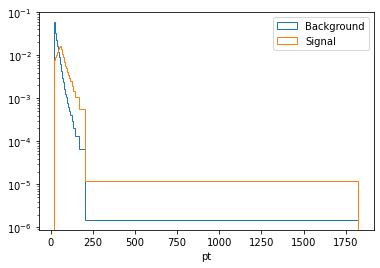

In [39]:
# restart weights calculation with the these corrected bins

# histograms
# pt_bins ---> edge_var_pt

h_pt_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["pt"], 
                        weights = totald[ totald["truth_label"] == 0]["weight_glob"],
                        histtype='step', log = True, bins = edge_var_pt, density='true',
                        label='Background')

h_pt_sig = plt.hist( totald[ totald["truth_label"]==1 ]["pt"] ,
                        weights = totald[ totald["truth_label"]==1 ]["weight_glob"],
                        histtype='step', log = True, bins = edge_var_pt, density='true',
                        label='Signal')

plt.gca().set(xlabel="pt")
plt.legend(loc="upper right")

In [40]:
# weight calculation

pt_w = h_pt_sig[0] / h_pt_bkg[0]
pt_w

array([0.1300864 , 0.17038431, 0.21680284, 0.26985644, 0.3390844 ,
       0.39511421, 0.45227224, 0.53371602, 0.61869149, 0.71071721,
       0.8129948 , 0.93400649, 1.0291329 , 1.14922867, 1.25234815,
       1.40274966, 1.57759261, 1.74016574, 1.94299972, 2.09809446,
       2.29766525, 2.45437682, 2.66740899, 2.80732039, 3.01373702,
       3.11019628, 3.3227102 , 3.3206906 , 3.46223987, 3.39170802,
       3.48624423, 3.49186256, 3.56237032, 3.72620008, 3.80342923,
       3.95608856, 4.11622968, 4.33462441, 4.48598434, 4.7413696 ,
       5.01051791, 5.36026789, 5.60901674, 5.97632791, 6.25232186,
       6.76521121, 7.18723545, 7.97943257, 8.13982947, 8.20303215])

In [41]:
# calcultate for each (not only bkg!) event what bin it belongs to

bin_idx_bkg_pt = np.digitize(totald["pt"], edge_var_pt)
idx_bkg_pt = pd.Series(bin_idx_bkg_pt)
idx_bkg_pt

0          31
1          24
2          33
3           6
4          27
           ..
7587263     8
7587264     7
7587265     1
7587266     6
7587267    14
Length: 7587268, dtype: int64

In [42]:
# map every bin to the corresponding weight

dfw_bkg_pt = idx_bkg_pt.map({i+1 : pt_w[i] for i in range(nbins_pt)})
dfw_bkg_pt

0          3.486244
1          2.807320
2          3.562370
3          0.395114
4          3.322710
             ...   
7587263    0.533716
7587264    0.452272
7587265    0.130086
7587266    0.395114
7587267    1.149229
Length: 7587268, dtype: float64

In [43]:
# attach weights to the dataframe, with condition on signal events

totald["weight_pt"] = dfw_bkg_pt.where( totald["truth_label"]==0 , 1.)
totald["weight_pt"]

0          1.000000
1          1.000000
2          1.000000
3          1.000000
4          1.000000
             ...   
7587263    0.533716
7587264    0.452272
7587265    0.130086
7587266    0.395114
7587267    1.149229
Name: weight_pt, Length: 7587268, dtype: float64

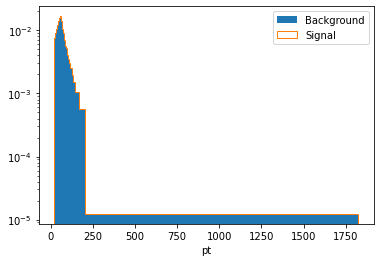

In [44]:
# histograms with pt_w on bkg


h_pt_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["pt"], 
                        weights = totald[ totald["truth_label"] == 0]["weight_glob"] * totald[ totald["truth_label"]==0 ]["weight_pt"],
                        histtype='stepfilled', log = True, bins = edge_var_pt, density='true',
                        label='Background')

h_pt_sig = plt.hist( totald[ totald["truth_label"]==1 ]["pt"] ,
                        weights = totald[ totald["truth_label"]==1 ]["weight_glob"] * totald[ totald["truth_label"]==1 ]["weight_pt"],
                        histtype='step', log = True, bins = edge_var_pt, density='true',
                        label='Signal')

plt.gca().set(xlabel="pt")
plt.legend(loc="upper right")

In [45]:
# test on correlation: **total weights**

totald["weight_tot"] = totald["weight_pt"] * totald["weight_eta"] * totald["weight_glob"]

Text(0.5, 1.0, 'Eta with total weights')

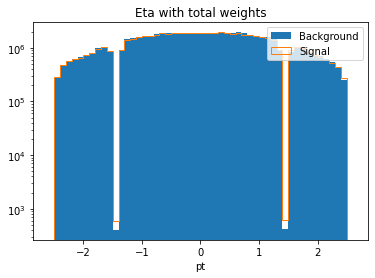

In [46]:
# final weighted eta plot

# histograms
h_eta_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["eta"] ,
                     weights = totald[ totald["truth_label"]==0 ]["weight_tot"],
                     histtype='stepfilled', bins = eta_bins,
                     label='Background')


h_eta_sig = plt.hist( totald[ totald["truth_label"]==1 ]["eta"] ,
                     weights = totald[ totald["truth_label"]==1 ]["weight_tot"],
                     histtype='step', log = True, bins = eta_bins,
                     label='Signal')

plt.gca().set(xlabel="pt")
plt.legend(loc="upper right")
plt.title("Eta with total weights")

In [ ]:
# final weighted pt plot


h_pt_bkg = plt.hist( totald[ totald["truth_label"]==0 ]["pt"], 
                        weights = totald[ totald["truth_label"] == 0]["weight_tot"],
                        histtype='stepfilled', log = True, bins = edge_var_pt, density='true',
                        label='Background')

h_pt_sig = plt.hist( totald[ totald["truth_label"]==1 ]["pt"] ,
                        weights = totald[ totald["truth_label"]==1 ]["weight_tot"],
                        histtype='step', log = True, bins = edge_var_pt, density='true',
                        label='Signal')

plt.gca().set(xlabel="pt")
plt.legend(loc="upper right")
plt.title("pt with total weights")

Text(0.5, 1.0, 'pt with total weights')